# Vertex Pipelines: Vertex-AI: Build a What-If Model & Deploy using Vertex AI-Pipelines


## Overview


This notebook shows how to use the components defined in [`google_cloud_pipeline_components`](https://github.com/kubeflow/pipelines/tree/master/components/google-cloud) to build an custom model workflow on [Vertex Pipelines](https://cloud.google.com/vertex-ai/docs/pipelines).

### Objective

In this example, you'll learn how to use components from `google_cloud_pipeline_components` to:
- create a _Dataset_ using data in cloud storage
- train an Custom AI model
- deploy the trained model to an _endpoint_ for serving

The components are [documented here](https://google-cloud-pipeline-components.readthedocs.io/en/latest/google_cloud_pipeline_components.aiplatform.html#module-google_cloud_pipeline_components.aiplatform).


The components are [documented here](https://google-cloud-pipeline-components.readthedocs.io/en/latest/google_cloud_pipeline_components.aiplatform.html#module-google_cloud_pipeline_components.aiplatform).
(From that page, see also the `CustomPythonPackageTrainingJobRunOp` and `CustomContainerTrainingJobRunOp` components, which similarly run 'custom' training, but as with the related `google.cloud.aiplatform.CustomContainerTrainingJob` and `google.cloud.aiplatform.CustomPythonPackageTrainingJob` methods from the [Vertex AI SDK](https://googleapis.dev/python/aiplatform/latest/aiplatform.html), also upload the trained model).

### Costs 

This tutorial uses billable components of Google Cloud:

* What-if Analysis Tool
* Vertex AI Training and Serving
* Cloud Storage



### Set up your  development environment

**Please note that the environment for the following notebook steps can be run on Google Cloud Notebooks**, your environment already meets
all the requirements to run this notebook.

## Before you begin

This notebook does not require a GPU runtime.



**Note**: Jupyter runs lines prefixed with `!` as shell commands, and it interpolates Python variables prefixed with `$` into these commands.

### Install additional packages


In [39]:
!pip3 install --quiet xgboost==1.2
!pip3 install --quiet google_cloud_pipeline_components==0.1.6

### Restart the kernel

After you install the additional packages, you need to restart the notebook kernel so it can find the packages.

In [1]:
# Automatically restart kernel after installs
import os

if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

Check the versions of the packages you installed.  The KFP SDK version should be >=1.6. 


** If this step takes a long time to execute, then from the menu on the top, goto Kernel --> Restart Kernel*

In [2]:
#test the version of Kfp - should be >= 1.6

import kfp
print('KFP SDK version: {}'.format(kfp.__version__))

KFP SDK version: 1.8.5


In [40]:
import uuid

import pandas as pd
import xgboost as xgb
import numpy as np
import collections
import witwidget

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import shuffle
from witwidget.notebook.visualization import WitWidget, WitConfigBuilder


import kfp
from google.cloud import aiplatform
from google_cloud_pipeline_components import aiplatform as gcc_aip
from kfp.v2 import compiler
from kfp.v2.google.client import AIPlatformClient
from kfp.v2 import compiler
from kfp.v2.dsl import component
from kfp.v2.google import experimental
from kfp.v2.google.client import AIPlatformClient

Check your project_id in the cell below, if you don't see an output with a project id - then you will set it up in the next step. 

In [42]:
import os

PROJECT_ID = ""

# Get your Google Cloud project ID from gcloud
if not os.getenv("IS_TESTING"):
    shell_output=!gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID: ", PROJECT_ID)


Project ID:  ai-ml-workshop


Ignore the cell below if you see the project id - Otherwise, set your project ID here below. Replace "CHANGE_THIS" to your project_id

In [43]:
if PROJECT_ID == "" or PROJECT_ID is None:
    PROJECT_ID = "<CHANGE_THIS>"  # @param {type:"string"}

#### Timestamp

If you are in a live tutorial session, you might be using a shared test account or project. To avoid name collisions between users on resources created, you create a timestamp for each instance session, and append it onto the name of resources you create in this tutorial.

In [44]:
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

### The next few steps will create a Cloud Storage bucket and copy the necessary files to the bucket. 

**Note for your information only**
You may also change the `REGION` variable, which is used for operations
throughout the rest of this notebook. Make sure to [choose a region where Vertex AI services are
available](https://cloud.google.com/vertex-ai/docs/general/locations#available_regions). You may
not use a Multi-Regional Storage bucket for training with Vertex AI.

In [45]:
#BUCKET_NAME = "gs://project849089-bucket/vai"  # @param {type:"string"}
REGION = "us-central1"  # @param {type:"string"}
BUCKET_NAME = "gs://" + PROJECT_ID + "_vertexai_" + TIMESTAMP
MODEL_NAME = 'xgb_mortgage_whatif'

print(BUCKET_NAME)

gs://ai-ml-workshop_vertexai_20220308190002


In [46]:
COLUMN_NAMES = collections.OrderedDict({
 'as_of_year': np.int16,
 'agency_code': 'category',
 'loan_type': 'category',
 'property_type': 'category',
 'loan_purpose': 'category',
 'occupancy': np.int8,
 'loan_amt_thousands': np.float64,
 'preapproval': 'category',
 'county_code': np.float64,
 'applicant_income_thousands': np.float64,
 'purchaser_type': 'category',
 'hoepa_status': 'category',
 'lien_status': 'category',
 'population': np.float64,
 'ffiec_median_fam_income': np.float64,
 'tract_to_msa_income_pct': np.float64,
 'num_owner_occupied_units': np.float64,
 'num_1_to_4_family_units': np.float64,
 'approved': np.int8
})

In [47]:
!gsutil cp 'gs://mortgage_dataset_files/mortgage-small.csv' ./mortgage-data.csv

Copying gs://mortgage_dataset_files/mortgage-small.csv...
| [1 files][330.8 MiB/330.8 MiB]                                                
Operation completed over 1 objects/330.8 MiB.                                    


In [48]:
data = pd.read_csv(
 'mortgage-data.csv',
 index_col=False,
 dtype=COLUMN_NAMES
)
data = data.dropna()
data = shuffle(data, random_state=2)
data.head()

,as_of_year,agency_code,loan_type,property_type,loan_purpose,occupancy,loan_amt_thousands,preapproval,county_code,applicant_income_thousands,purchaser_type,hoepa_status,lien_status,population,ffiec_median_fam_income,tract_to_msa_income_pct,num_owner_occupied_units,num_1_to_4_family_units,approved
310650,2016,Consumer Financial Protection Bureau (CFPB),"Conventional (any loan other than FHA, VA, FSA...",One to four-family (other than manufactured ho...,Refinancing,1,110.0,Not applicable,119.0,55.0,Freddie Mac (FHLMC),Not a HOEPA loan,Secured by a first lien,5930.0,64100.0,98.81,1305.0,1631.0,1
630129,2016,Department of Housing and Urban Development (HUD),"Conventional (any loan other than FHA, VA, FSA...",One to four-family (other than manufactured ho...,Home purchase,1,480.0,Not applicable,33.0,270.0,Loan was not originated or was not sold in cal...,Not a HOEPA loan,Secured by a first lien,4791.0,90300.0,144.06,1420.0,1450.0,0
715484,2016,Federal Deposit Insurance Corporation (FDIC),"Conventional (any loan other than FHA, VA, FSA...",One to four-family (other than manufactured ho...,Refinancing,2,240.0,Not applicable,59.0,96.0,"Commercial bank, savings bank or savings assoc...",Not a HOEPA loan,Secured by a first lien,3439.0,105700.0,104.62,853.0,1076.0,1
887708,2016,Office of the Comptroller of the Currency (OCC),"Conventional (any loan other than FHA, VA, FSA...",One to four-family (other than manufactured ho...,Refinancing,1,76.0,Not applicable,65.0,85.0,Loan was not originated or was not sold in cal...,Not a HOEPA loan,Secured by a subordinate lien,3952.0,61300.0,90.93,1272.0,1666.0,1
719598,2016,National Credit Union Administration (NCUA),"Conventional (any loan other than FHA, VA, FSA...",One to four-family (other than manufactured ho...,Refinancing,1,100.0,Not applicable,127.0,70.0,Loan was not originated or was not sold in cal...,Not a HOEPA loan,Secured by a first lien,2422.0,46400.0,88.37,650.0,1006.0,1


In [49]:
# Class labels - 0: denied, 1: approved
print(data['approved'].value_counts())

labels = data['approved'].values
data = data.drop(columns=['approved'])

1    665389
0    334610
Name: approved, dtype: int64


In [50]:
dummy_columns = list(data.dtypes[data.dtypes == 'category'].index)
data = pd.get_dummies(data, columns=dummy_columns)

data.head()

,as_of_year,occupancy,loan_amt_thousands,county_code,applicant_income_thousands,population,ffiec_median_fam_income,tract_to_msa_income_pct,num_owner_occupied_units,num_1_to_4_family_units,...,"purchaser_type_Life insurance company, credit union, mortgage bank, or finance company",purchaser_type_Loan was not originated or was not sold in calendar year covered by register,purchaser_type_Other type of purchaser,purchaser_type_Private securitization,hoepa_status_HOEPA loan,hoepa_status_Not a HOEPA loan,lien_status_Not applicable (purchased loans),lien_status_Not secured by a lien,lien_status_Secured by a first lien,lien_status_Secured by a subordinate lien
310650,2016,1,110.0,119.0,55.0,5930.0,64100.0,98.81,1305.0,1631.0,...,0,0,0,0,0,1,0,0,1,0
630129,2016,1,480.0,33.0,270.0,4791.0,90300.0,144.06,1420.0,1450.0,...,0,1,0,0,0,1,0,0,1,0
715484,2016,2,240.0,59.0,96.0,3439.0,105700.0,104.62,853.0,1076.0,...,0,0,0,0,0,1,0,0,1,0
887708,2016,1,76.0,65.0,85.0,3952.0,61300.0,90.93,1272.0,1666.0,...,0,1,0,0,0,1,0,0,0,1
719598,2016,1,100.0,127.0,70.0,2422.0,46400.0,88.37,650.0,1006.0,...,0,1,0,0,0,1,0,0,1,0


In [51]:
x,y = data.values,labels
x_train,x_test,y_train,y_test = train_test_split(x,y)

In [52]:
model = xgb.XGBClassifier(
    objective='reg:logistic'
)

In [53]:
model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='reg:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [54]:
y_pred = model.predict(x_test)
acc = accuracy_score(y_test, y_pred.round())
print(acc, '\n')

0.873908 



In [55]:
model.save_model('model.bst')

In [56]:
num_wit_examples = 500
test_examples = np.hstack((x_test[:num_wit_examples],y_test[:num_wit_examples].reshape(-1,1)))

In [57]:
config_builder = (WitConfigBuilder(test_examples.tolist(), data.columns.tolist() + ['mortgage_status'])
  .set_custom_predict_fn(model.predict_proba)
  .set_target_feature('mortgage_status')
  .set_label_vocab(['denied', 'approved']))
WitWidget(config_builder, height=800)

WitWidget(config={'model_type': 'classification', 'label_vocab': ['denied', 'approved'], 'feature_names': ['as…

In [68]:
!gsutil mb -l us-central1 $BUCKET_NAME

Creating gs://ai-ml-workshop_vertexai_20220308190002/...


In [69]:
!gsutil cp ./model.bst $BUCKET_NAME

Copying file://./model.bst [Content-Type=application/octet-stream]...
/ [1 files][293.9 KiB/293.9 KiB]                                                
Operation completed over 1 objects/293.9 KiB.                                    


Finally, validate access to your Cloud Storage bucket by examining its contents. You should the model.bst.

In [70]:
! gsutil ls -al $BUCKET_NAME

    300967  2022-03-08T19:07:54Z  gs://ai-ml-workshop_vertexai_20220308190002/model.bst#1646766474120494  metageneration=1
TOTAL: 1 objects, 300967 bytes (293.91 KiB)


**Setting up Service Account**

Refer to the step#2 and #3 of the Qwiklabs.

**Excerpt from the Qwiklab:**

Once the Vertex AI API is enabled, you will be taken to the Vertex-AI API properties page. Alternatively, you can click on the “Manage” button to reach here.


From the left side of the screen, click on “Credentials” and make a note of the service account of the compute service account. This service account will be used to grant access to the bucket from the Vertex AI notebooks in the next few steps.
For e.g. It will look something like this
"1023279203633-compute@developer.gserviceaccount.com"

In [74]:
# you can get this from the Vertex AI API Credentials page, it will be something like this [account]-compute@developer.gserviceaccount.com 
#for e.g. service_account = '1023279203633-compute@developer.gserviceaccount.com'

service_account = '<ENTER SERVICE ACCOUNT SAVED EARLIER>'  # <<- Please change this to service account copied earlier


In [75]:
!gsutil iam ch serviceAccount:$service_account:roles/storage.admin $BUCKET_NAME

### Import libraries and define constants

Define some constants. 


In [76]:
PATH=%env PATH
%env PATH={PATH}:/home/jupyter/.local/bin

USER = "xgb_whatif"  
PIPELINE_ROOT = "{}/pipeline_root/{}".format(BUCKET_NAME, USER)

PIPELINE_ROOT

env: PATH=/usr/local/cuda/bin:/opt/conda/bin:/opt/conda/condabin:/usr/local/bin:/usr/bin:/bin:/usr/local/games:/usr/games:/home/jupyter/.local/bin:/home/jupyter/.local/bin:/home/jupyter/.local/bin:/home/jupyter/.local/bin


'gs://ai-ml-workshop_vertexai_20220308190002/pipeline_root/xgb_whatif'

## Define a custom model pipeline that uses components from google_cloud_pipeline_components

Define the pipeline:

Pipeline module consists of 2 tasks / operations: 

1- **Create a Model task:** A Model created under the Model section of the Vertex AI 

2- **Create an EndPoint task:** Crete an endpoint

3- **Model deploy task:** Model deployment task with project name and machine_type. Please note that the parameter machine_type is mandatory.

Set some variables that will be used in constructing the args passed to the custom training job and setting pipeline params.

In [77]:
REGION = "us-central1"  # @param {type:"string"}
BUCKET_NAME = "gs://" + PROJECT_ID + "_vertexai_" + TIMESTAMP
MODEL_NAME = 'xgb_mortgage_whatif'


Set some variables that will be used in constructing the args passed to the custom training job and setting pipeline params.

Next, you define a component with which the custom training job is run.  For this example, this component doesn't do anything (but run a print statement).

Now, you define the pipeline.  

Then, [`google_cloud_pipeline_components`](https://github.com/kubeflow/pipelines/tree/master/components/google-cloud) components are used to define the rest of the pipeline: upload the model, create an endpoint, and deploy the model to the endpoint. (While not shown in this example, the model deploy will create an endpoint if one is not provided.)

In [78]:
@kfp.dsl.pipeline(name="xgb-mortgage-whatif-model" + str(uuid.uuid4()))
def pipeline(
    project: str = PROJECT_ID,
    model_display_name: str = MODEL_NAME,
    serving_container_image_uri: str = 'us-docker.pkg.dev/vertex-ai/prediction/xgboost-cpu.1-3:latest',
):

    

    model_upload_op = gcc_aip.ModelUploadOp(
        project=project,
        display_name=model_display_name,
        artifact_uri=BUCKET_NAME,
        serving_container_image_uri=serving_container_image_uri,
        serving_container_environment_variables={"NOT_USED": "NO_VALUE"},
    )

    endpoint_create_op = gcc_aip.EndpointCreateOp(
        project=project,
        display_name="pipelines-created-endpoint",
    )

    model_deploy_op = gcc_aip.ModelDeployOp(  
        project=project,
        endpoint=endpoint_create_op.outputs["endpoint"],
        model=model_upload_op.outputs["model"],
        deployed_model_display_name=model_display_name,
        machine_type="n1-standard-4",
    )

## Compile and run the pipeline

Now, you're ready to compile the pipeline:

The pipeline compilation generates the `train_whatif_model.json` job spec file.

Next, instantiate an API client object:

In [79]:
from kfp.v2 import compiler  # noqa: F811

compiler.Compiler().compile(
    pipeline_func=pipeline, package_path="train_whatif_model.json"
)

** Please note that you might get a FutureWarning, after running this cell below. please ignore. 

In [80]:
from kfp.v2.google.client import AIPlatformClient  # noqa: F811

api_client = AIPlatformClient(
    project_id=PROJECT_ID,
    region=REGION,
)

Then, you run the defined pipeline like this: (The pipeline may take 10-12 minutes to run)

Running the cell below will provide you a link that shows the status of the pipeline being run. Please click on the link to see the pipeline, as shown in the screenshot below.

In [81]:
response = api_client.create_run_from_job_spec(
    "train_whatif_model.json",
    pipeline_root=PIPELINE_ROOT,
    parameter_values={"project": PROJECT_ID},
)

Click on the generated link to see your run in the Cloud Console.  It should look something like this:

You can also try clicking on the "Expanded Artifacts" toggle button on the top. 



## Observe

Observe the corresponding entries in the pipeline and models section from the Vertex AI interface.



In this example, you learnt how to use components from `google_cloud_pipeline_components` to:

- create a _Dataset_ using data in cloud storage
- train an Custom AI model
- deploy the trained model to an _endpoint_ for serving


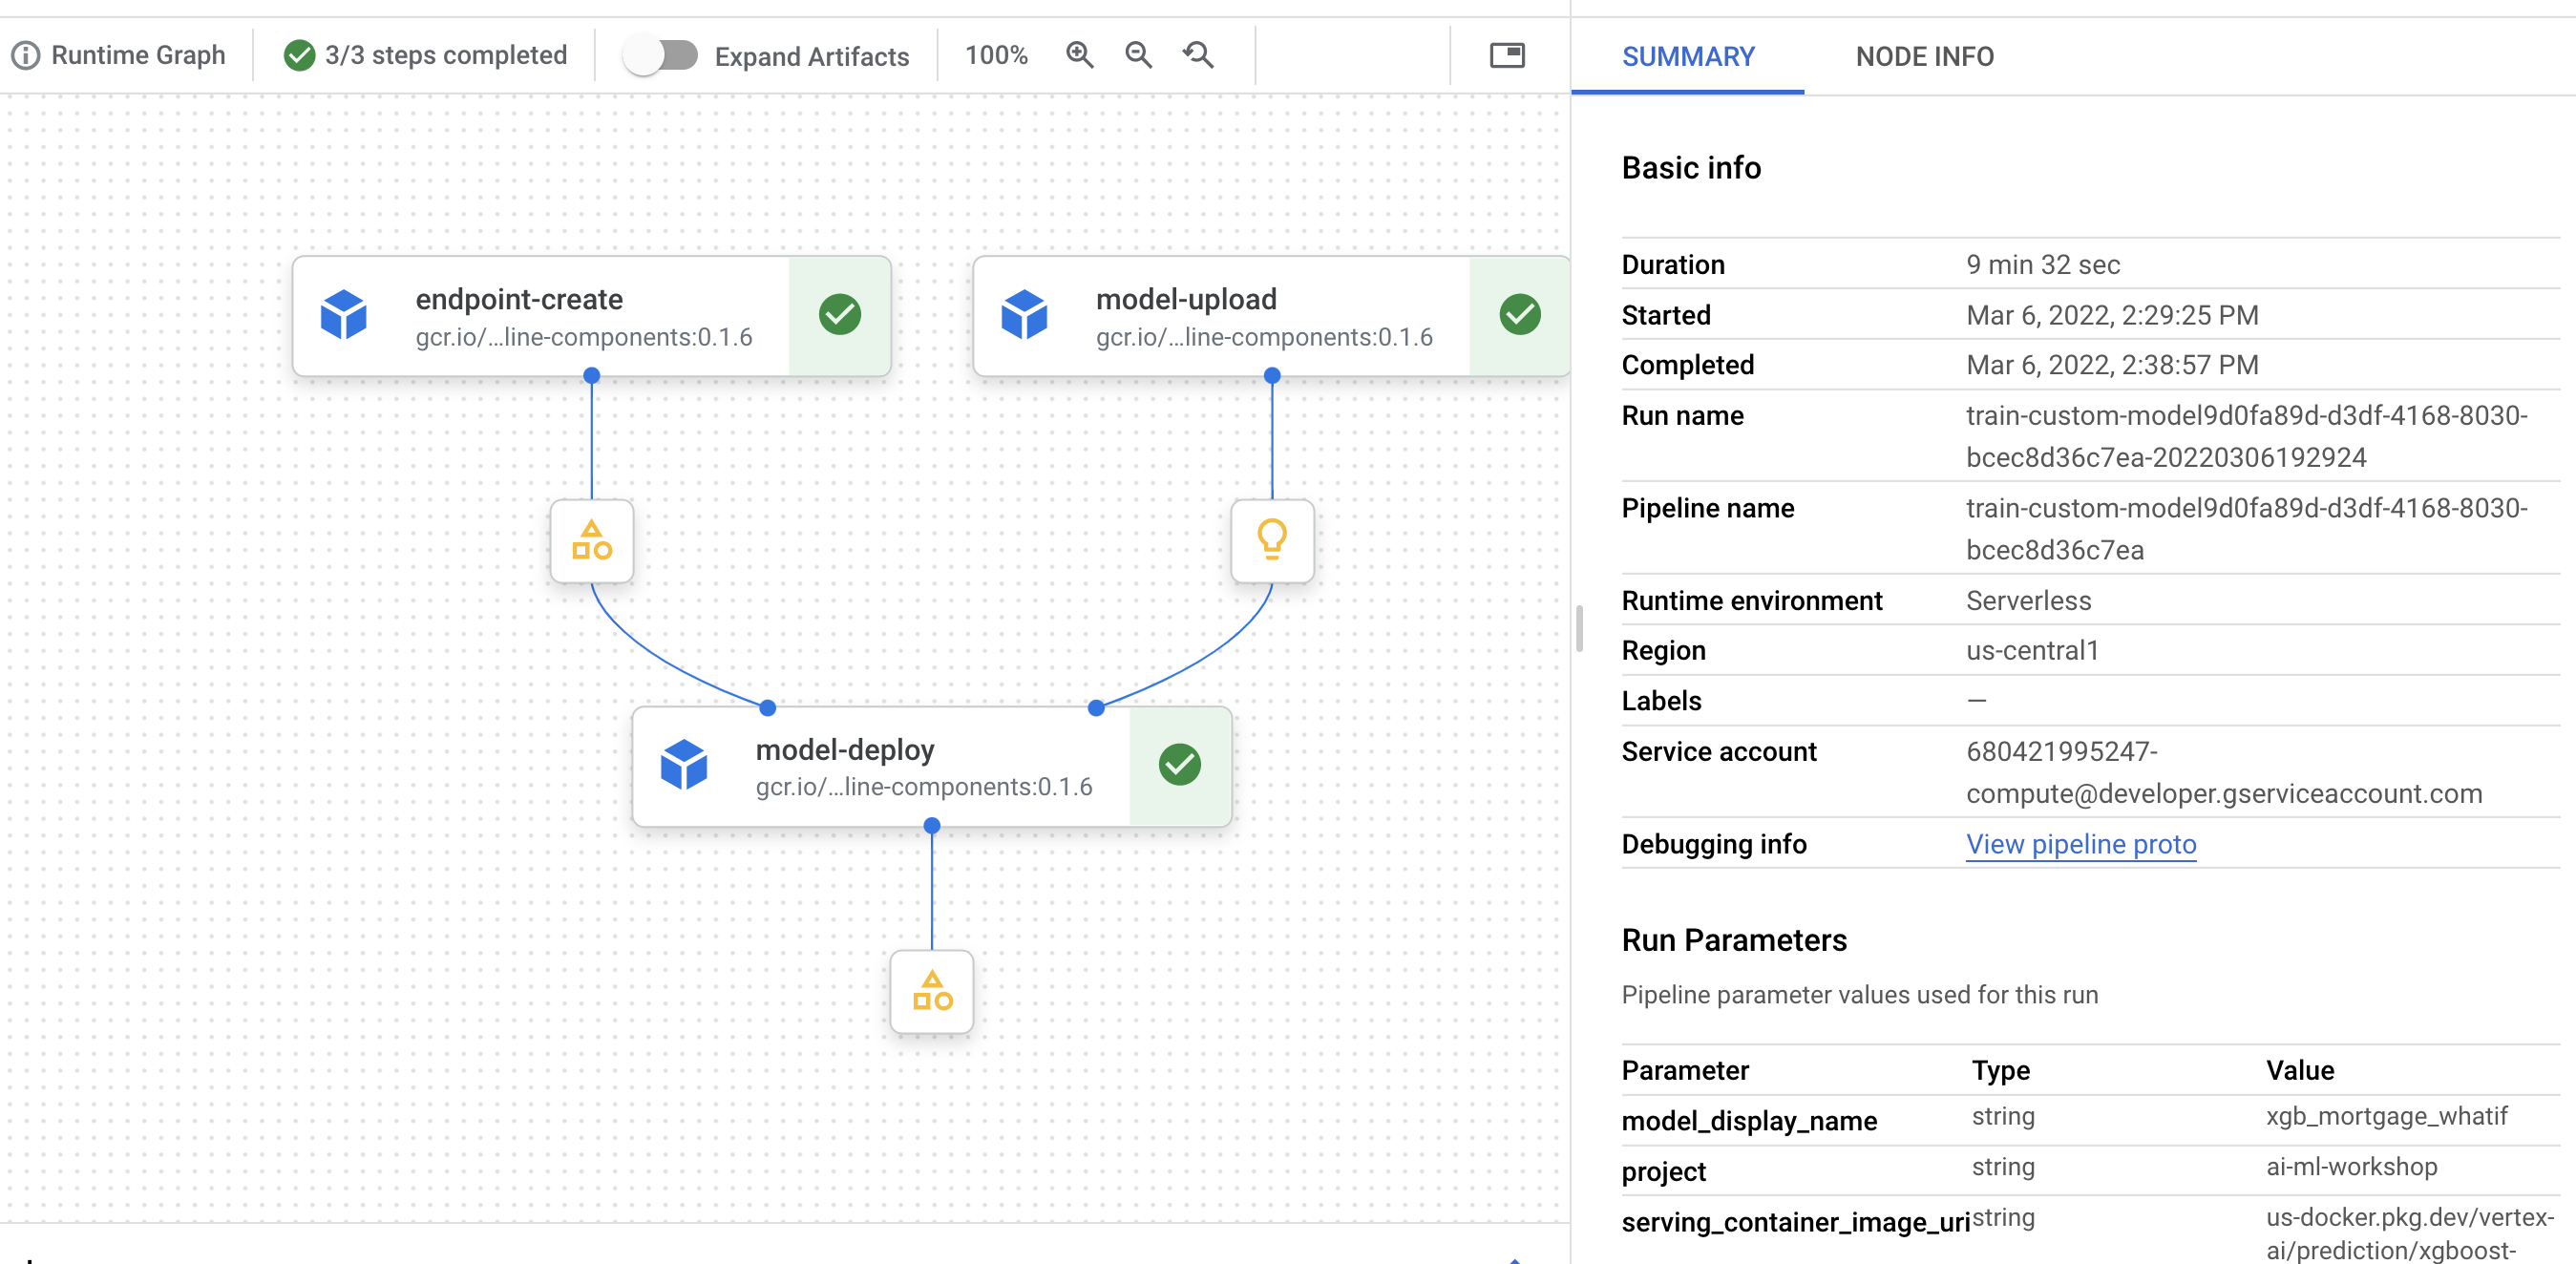

In [ ]:
# Warning: this command will delete ALL Cloud Storage objects under the PIPELINE_ROOT path.
# ! gsutil -m rm -r $PIPELINE_ROOT

In [ ]:
# Copyright 2021 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.